In [5]:
import gym
from gym import spaces
import numpy as np

class LunarLanderPlusEnv(gym.Env):
    def __init__(self):
        super(LunarLanderPlusEnv, self).__init__()
        self.observation_space = spaces.Box(low=np.array([-1, -1, -1, -1, 0, 0]), high=np.array([1, 1, 1, 1, 1, 5]), dtype=np.float32)
        self.action_space = spaces.Discrete(4)
        self.reset()
    
    def reset(self):
        self.state = np.array([0, 0, 0, 0, 1, np.random.randint(1, 10)])  # randint부분이 탑승 인원수
        self.done = False
        return self.state
    
    def step(self, action):
        x, y, vx, vy, fuel, passengers = self.state
        if action == 0:
            vx -= 0.01
        elif action == 1:
            vx += 0.01
        elif action == 2:
            vy += 0.1
            fuel -= 0.1 * (passengers + 1)  # 탑승 인원수에 비례하여 연료 소비
        
        x += vx
        y += vy
        fuel -= 0.01 * (passengers + 1)  # 마찬가지로 탑승 인원수에 비례하여 연료 소비 
        
        reward = -np.sqrt(x**2 + y**2)
        
        if y >= 1:
            reward += 100
            self.done = True
        if fuel <= 0:
            reward -= 100
            self.done = True
        
        self.state = np.array([x, y, vx, vy, fuel, passengers])
        return self.state, reward, self.done, {}

    def render(self):
        print(f"State: {self.state}")

env = LunarLanderPlusEnv()


/home/chan4im/anaconda3/envs/robot/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.best_reward = -float('inf')
        self.best_model_path = "best_dqn_model.pth"

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.model(state)
        return torch.argmax(action_values[0]).item()

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(torch.FloatTensor(next_state).unsqueeze(0))[0]).item()
            target_f = self.model(torch.FloatTensor(state).unsqueeze(0))
            with torch.no_grad():
                target_f[0][action] = target
            self.optimizer.zero_grad()
            loss = self.criterion(target_f, self.model(torch.FloatTensor(state).unsqueeze(0)))
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save_best_model(self, reward):
        if reward > self.best_reward:
            self.best_reward = reward
            torch.save(self.model.state_dict(), self.best_model_path)

    def load_best_model(self):
        self.model.load_state_dict(torch.load(self.best_model_path))

env = LunarLanderPlusEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episodes = 1000
batch_size = 64

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        if done:
            agent.update_target_model()
            agent.save_best_model(total_reward)
            print(f"Episode: {e + 1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
            break
        
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

agent.load_best_model()


Episode: 1/1000, Reward: -100.32273624037278, Epsilon: 1.00
Episode: 2/1000, Reward: -100.39999999999999, Epsilon: 1.00
Episode: 3/1000, Reward: -102.93894401984642, Epsilon: 1.00
Episode: 4/1000, Reward: -101.10181496296718, Epsilon: 1.00
Episode: 5/1000, Reward: -100.8383335457467, Epsilon: 1.00
Episode: 6/1000, Reward: -101.67881630757469, Epsilon: 1.00
Episode: 7/1000, Reward: -100.52527475142466, Epsilon: 1.00
Episode: 8/1000, Reward: -104.06354398950678, Epsilon: 1.00
Episode: 9/1000, Reward: 96.35844935646153, Epsilon: 1.00
Episode: 10/1000, Reward: -101.41000000000001, Epsilon: 0.95
Episode: 11/1000, Reward: -100.39999999999999, Epsilon: 0.95
Episode: 12/1000, Reward: -4.33248054891528, Epsilon: 0.90
Episode: 13/1000, Reward: -100.37180339887499, Epsilon: 0.85
Episode: 14/1000, Reward: 93.29582837595075, Epsilon: 0.81
Episode: 15/1000, Reward: -102.52210125909895, Epsilon: 0.73
Episode: 16/1000, Reward: -2.8020087030038177, Epsilon: 0.71
Episode: 17/1000, Reward: -100.704305016

탑승 인원수 | 최적 연료 사용량
-----------------------------
0          | 0.4580
1          | 0.8280
2          | 0.9870
3          | 1.0080
4          | 1.0750
5          | 1.1460


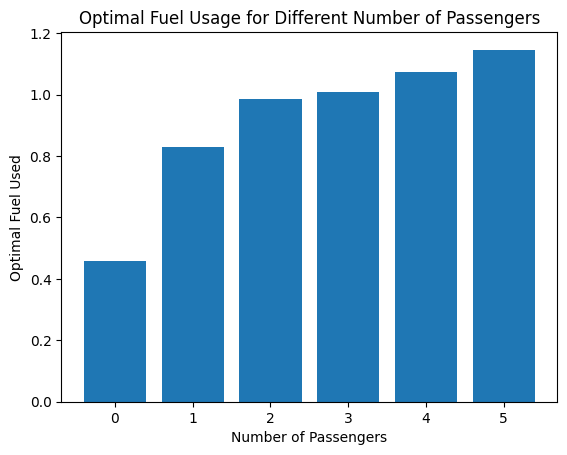

In [11]:
import matplotlib.pyplot as plt

def plot_optimal_fuel(passenger_fuel):
    passengers = list(passenger_fuel.keys())
    fuels = list(passenger_fuel.values())
    
    plt.bar(passengers, fuels)
    plt.xlabel('Number of Passengers')
    plt.ylabel('Optimal Fuel Used')
    plt.title('Optimal Fuel Usage for Different Number of Passengers')
    plt.show()

def print_fuel_usage(passenger_fuel):
    print("탑승 인원수 | 최적 연료 사용량")
    print("-----------------------------")
    for passengers, fuel in passenger_fuel.items():
        print(f"{passengers:<10} | {fuel:.4f}")

agent.load_best_model()
passenger_fuel = {}

for passengers in range(6):
    total_fuel_used = 0
    trials = 10
    for _ in range(trials):
        state = env.reset()
        state[-1] = passengers
        total_fuel = 1  # 초기 연료량을 1이라고 가정
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_fuel = state[4]  # 남은 연료량
        total_fuel_used += (1 - total_fuel)  # 소비된 연료량
    
    passenger_fuel[passengers] = total_fuel_used / trials  # 평균 연료 소모량


print_fuel_usage(passenger_fuel)
plot_optimal_fuel(passenger_fuel)